In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the data

In [83]:
df = pd.read_csv("drive/MyDrive/AS_Project/data_reindexed.csv")

In [4]:
doses_scaled = np.load("drive/MyDrive/AS_Project/doses_scaled.npy", mmap_mode='r')

In [5]:
print(type(doses_scaled))


<class 'numpy.memmap'>


In [7]:
doses_scaled.shape

(310, 147, 168, 201)

## Outliers


In [143]:
print(f"Min dose : {doses_scaled.min():.2f}")
print(f"Max dose : {doses_scaled.max():.2f}")
print(f"Mean dose (1st patient) : {doses_scaled[0].mean():.2f}")


Min dose: 0.00
Max dose: 620.71
Mean dose (1st patient): 16.96


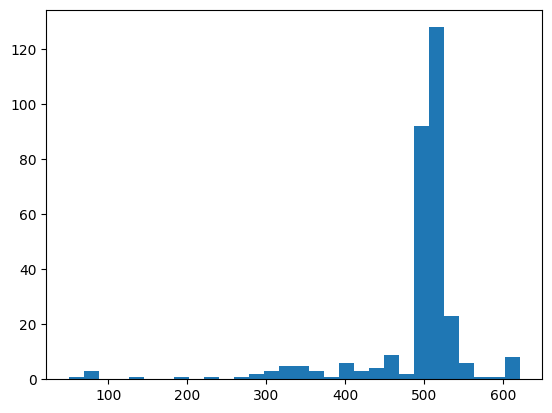

In [9]:
max_dose_per_patient = np.array([doses_scaled[i].max() for i in range(doses_scaled.shape[0])])
plt.hist(max_dose_per_patient,bins=30)
plt.show()

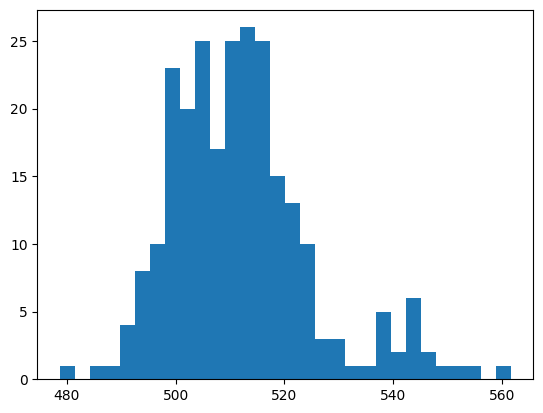

In [137]:
filtered_max_doses = max_dose_per_patient[(max_dose_per_patient > 475) & (max_dose_per_patient < 565)]
plt.hist(filtered_max_doses,bins=30)
plt.show()

In [138]:
print(f"Number of patients kept after filtering by maximum dose of each patient : {len(filtered_max_doses)}")

Number of patients kept after filtering by maximum dose of each patient : 251


In [140]:
index_max_outliers = np.where((max_dose_per_patient <= 475) | (max_dose_per_patient >= 565))[0]
print("List of patient's index outliers based on maximum dose of each patient :\n")
index_max_outliers

List of patient's index outliers based on maximum dose of each patient :



array([ 10,  29,  31,  35,  55,  58,  60,  65,  69,  73,  77,  80,  83,
        88,  91,  92,  93,  96,  99, 107, 132, 136, 141, 142, 146, 148,
       163, 164, 167, 194, 227, 241, 246, 247, 249, 250, 251, 252, 253,
       254, 258, 259, 260, 262, 264, 266, 267, 271, 275, 280, 281, 284,
       286, 290, 294, 295, 301, 307, 308])

In [14]:
for i in index_max_outliers:
  print(f"Patient {i} : {max_dose_per_patient[i]} Gy")

Patient 10 : 187.94454956054688 Gy
Patient 29 : 447.94158935546875 Gy
Patient 31 : 592.3250122070312 Gy
Patient 35 : 338.314208984375 Gy
Patient 55 : 346.7013244628906 Gy
Patient 58 : 313.72662353515625 Gy
Patient 60 : 602.840576171875 Gy
Patient 65 : 322.06640625 Gy
Patient 69 : 326.33941650390625 Gy
Patient 73 : 620.7101440429688 Gy
Patient 77 : 351.53204345703125 Gy
Patient 80 : 608.9583129882812 Gy
Patient 83 : 235.55775451660156 Gy
Patient 88 : 333.836181640625 Gy
Patient 91 : 318.5045471191406 Gy
Patient 92 : 606.9494018554688 Gy
Patient 93 : 318.26202392578125 Gy
Patient 96 : 84.72447204589844 Gy
Patient 99 : 355.40911865234375 Gy
Patient 107 : 338.1036682128906 Gy
Patient 132 : 439.3377380371094 Gy
Patient 136 : 451.57763671875 Gy
Patient 141 : 451.8414001464844 Gy
Patient 142 : 451.28326416015625 Gy
Patient 146 : 423.06732177734375 Gy
Patient 148 : 84.8342056274414 Gy
Patient 163 : 605.9368896484375 Gy
Patient 164 : 578.834716796875 Gy
Patient 167 : 299.38653564453125 Gy
Patie

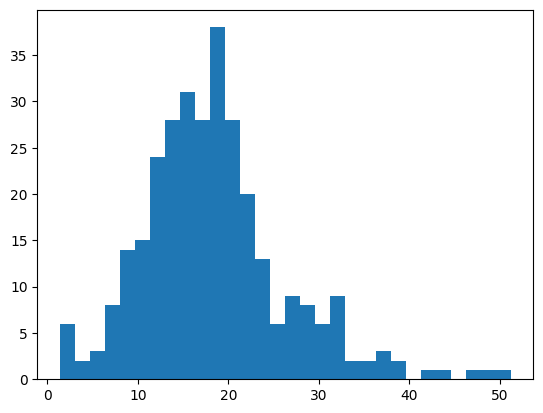

In [15]:
mean_dose_per_patient = np.array([doses_scaled[i].mean() for i in range(doses_scaled.shape[0])])
plt.hist(mean_dose_per_patient,bins=30)
plt.show()

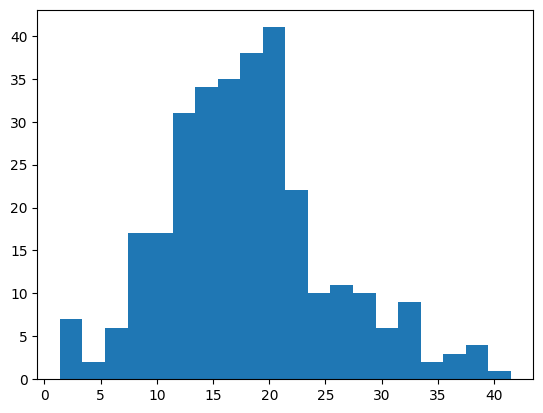

In [25]:
filtered_mean_doses = mean_dose_per_patient[mean_dose_per_patient <= 42]
plt.hist(filtered_mean_doses,bins=20)
plt.show()

In [136]:
print(f"Number of patients kept after filtering by mean dose of each patient : {len(filtered_mean_doses)}")

Number of patients kept after filtering by mean dose of each patient : 306


In [141]:
index_mean_outliers = np.where(mean_dose_per_patient > 42)[0]
print("List of patient's index outliers based on mean dose of each patient :\n")
index_mean_outliers

List of patient's index outliers based on mean dose of each patient :



array([ 61,  67, 156, 164])

In [30]:
for i in index_mean_outliers:
  print(f"Patient {i} : {mean_dose_per_patient[i]} Gy")

Patient 61 : 48.911224365234375 Gy
Patient 67 : 43.222007751464844 Gy
Patient 156 : 51.21149444580078 Gy
Patient 164 : 46.420223236083984 Gy


In [142]:
index_common_outliers = np.intersect1d(index_max_outliers, index_mean_outliers)
print("List of patient's index outliers based on maximum dose and mean dose of each patient :\n")
index_common_outliers

List of patient's index outliers based on maximum dose and mean dose of each patient :



array([164])

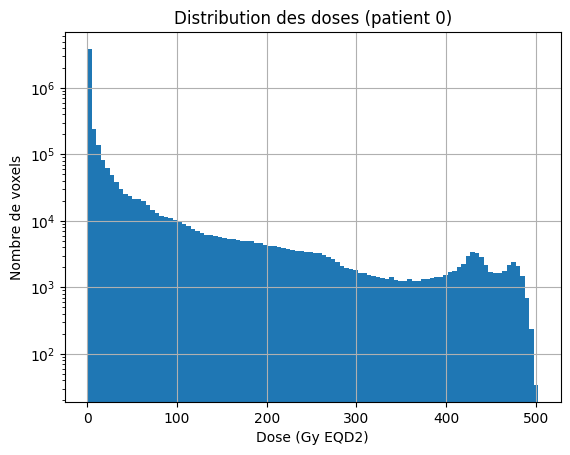

In [33]:
import matplotlib.pyplot as plt

plt.hist(doses_scaled[0].flatten(), bins=100)
plt.title("Doses distribution (patient 0)")
plt.xlabel("Dose")
plt.ylabel("Numbers of voxels")
plt.yscale("log")
plt.grid(True)
plt.show()


In [99]:
def compute_dose_descriptors(doses_scaled, voxel_volume_cc=0.001):
    """
    doses_scaled: ndarray (n_patients, x, y, z) with dose values in Gy
    voxel_volume_cc: volume of each voxel in cubic centimeters (default 1mm^3 = 0.001cc)
    Returns: pd.DataFrame with one row per patient and dose metrics
    """
    n_patients = doses_scaled.shape[0]
    descriptors = []

    # Define dose's thresholds for Vx
    dose_thresholds = [5, 10, 20, 30, 40]

    for i in range(n_patients):
        dose_3d = doses_scaled[i]
        dose_flat = dose_3d.flatten()

        # Sort the doses decreasingly according to Dcc
        sorted_dose = np.sort(dose_flat)[::-1]
        total_voxels = dose_flat.size

        # Maximum doses
        Dmax = sorted_dose[0]
        Dmean = dose_flat.mean()

        # Doses in the more exposed volumes
        n_voxels_2cc = int(2 / voxel_volume_cc)
        n_voxels_5cc = int(5 / voxel_volume_cc)

        D2cc = sorted_dose[:n_voxels_2cc].mean() if n_voxels_2cc < total_voxels else np.nan
        D5cc = sorted_dose[:n_voxels_5cc].mean() if n_voxels_5cc < total_voxels else np.nan

        # Volumes receiving > x threshold dose
        Vx = {}
        for x in dose_thresholds:
            Vx[f'V{x}'] = 100 * np.sum(dose_flat >= x) * voxel_volume_cc  # in cc
            Vx[f'V{x}_rel'] = 100 * np.mean(dose_flat >= x)  # in %

        # Stack the results
        patient_data = {
            'Dmax': Dmax,
            'Dmean': Dmean,
            'D2cc': D2cc,
            'D5cc': D5cc,
            **Vx
        }
        descriptors.append(patient_data)

    return pd.DataFrame(descriptors)


In [100]:
descriptors = compute_dose_descriptors(doses_scaled)

In [145]:
descriptors.head()

,Dmax,Dmean,D2cc,D5cc,V5,V5_rel,V10,V10_rel,V20,V20_rel,V30,V30_rel,V40,V40_rel
0,502.517883,16.959970,488.141541,483.156006,109855.9,22.130983,85619.0,17.248347,63395.6,12.771339,52229.7,10.521917,45381.4,9.142295
1,503.611053,21.596956,493.603180,490.781738,109100.3,21.978764,94772.3,19.092322,75697.9,15.249695,64306.9,12.954925,57017.4,11.486421
2,502.233368,19.709639,493.127747,489.203644,102104.7,20.569468,83992.0,16.920580,67871.9,13.673111,58908.1,11.867311,52047.7,10.485252
3,512.750916,13.033615,503.886719,500.307709,80207.9,16.158256,62997.4,12.691120,49654.2,10.003070,42749.4,8.612066,37194.8,7.493066
4,511.733246,17.811428,498.368195,494.021088,88379.5,17.804462,70355.6,14.173464,59009.2,11.887679,53356.8,10.748976,48707.1,9.812272


In [146]:
for i in [5,10,20,30,40] :
  descriptors[f"V{i}"] = descriptors[f"V{i}"]/1000

In [147]:
descriptors.head()

,Dmax,Dmean,D2cc,D5cc,V5,V5_rel,V10,V10_rel,V20,V20_rel,V30,V30_rel,V40,V40_rel
0,502.517883,16.959970,488.141541,483.156006,109.8559,22.130983,85.6190,17.248347,63.3956,12.771339,52.2297,10.521917,45.3814,9.142295
1,503.611053,21.596956,493.603180,490.781738,109.1003,21.978764,94.7723,19.092322,75.6979,15.249695,64.3069,12.954925,57.0174,11.486421
2,502.233368,19.709639,493.127747,489.203644,102.1047,20.569468,83.9920,16.920580,67.8719,13.673111,58.9081,11.867311,52.0477,10.485252
3,512.750916,13.033615,503.886719,500.307709,80.2079,16.158256,62.9974,12.691120,49.6542,10.003070,42.7494,8.612066,37.1948,7.493066
4,511.733246,17.811428,498.368195,494.021088,88.3795,17.804462,70.3556,14.173464,59.0092,11.887679,53.3568,10.748976,48.7071,9.812272


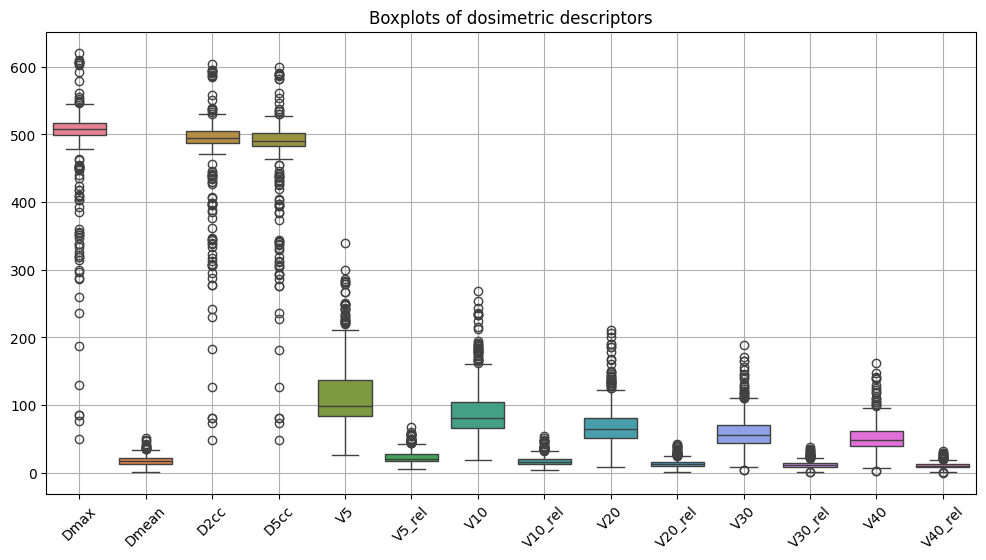

In [148]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=descriptors)
plt.xticks(rotation=45)
plt.title("Boxplots of dosimetric descriptors")
plt.grid(True)
plt.show()


### Finding outliers with PCA

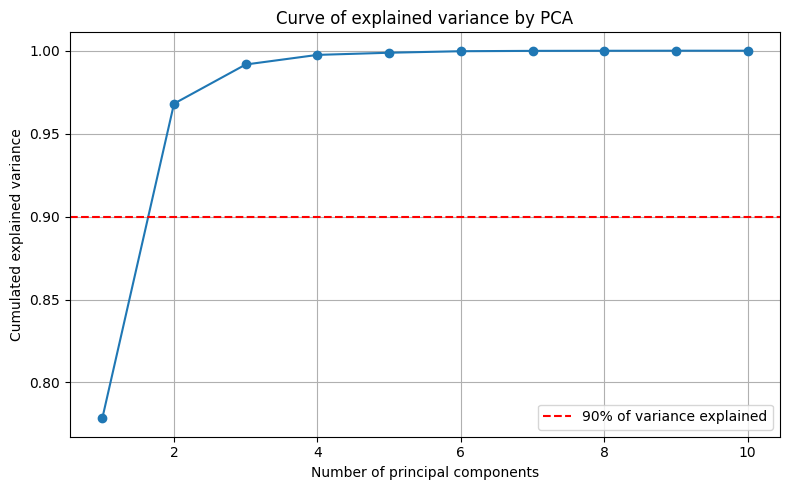

In [149]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize dosimetric descriptors
X_scaled = StandardScaler().fit_transform(descriptors)

# Apply PCA
pca = PCA(n_components=min(10, X_scaled.shape[1]))
pca.fit(X_scaled)

# Cumulated explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Number of principal components")
plt.ylabel("Cumulated explained variance")
plt.title("Curve of explained variance by PCA")
plt.grid(True)
plt.axhline(0.9, color='red', linestyle='--', label='90% of variance explained')
plt.legend()
plt.tight_layout()
plt.show()


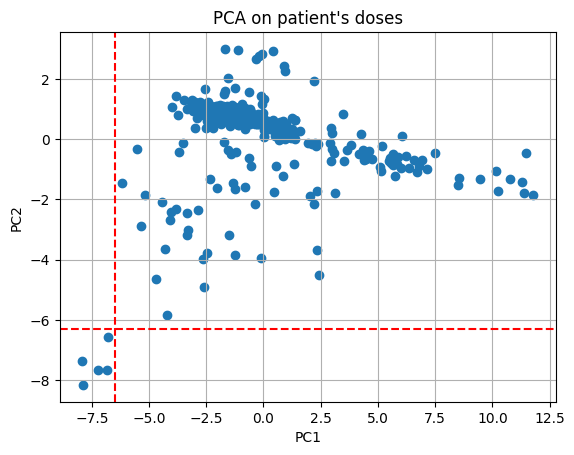

In [150]:
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA on patient's doses")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axhline(y=-6.3, color='r', linestyle='--')
plt.axvline(x=-6.5, color='r', linestyle='--')
plt.grid(True)
plt.show()


In [104]:
pca_outliers = X_pca[(X_pca[:, 0] < -6.5) & (X_pca[:, 1] < -6.3)]
pca_outliers

array([[-7.91620362e+00, -7.36739996e+00, -2.42742519e-01,
         3.77659970e-01,  1.46111507e-03, -4.38572634e-02,
         7.80118657e-04, -1.27540216e-02,  8.50286000e-03,
        -2.32979227e-15],
       [-6.81956056e+00, -7.66194409e+00,  2.22883081e-01,
         4.08145010e-01, -2.99626491e-02, -7.02291327e-02,
        -5.02260374e-02, -4.51426323e-03, -9.45031985e-04,
        -7.94916019e-17],
       [-7.87102807e+00, -8.16162500e+00, -5.81862182e-02,
         4.79163918e-01, -2.62056769e-02, -5.96683954e-02,
         2.81635789e-02, -2.32244930e-03, -1.69212194e-03,
        -7.94399730e-16],
       [-6.80271153e+00, -6.56947696e+00, -2.71706315e-01,
         1.79470149e-01, -1.50069181e-02, -6.01099761e-02,
         5.22372170e-03, -4.69594367e-03,  2.33127327e-03,
        -1.36216597e-15],
       [-7.25215661e+00, -7.68034272e+00, -4.48577603e-01,
         2.21166945e-01,  1.28431028e-03, -7.47989973e-02,
        -4.89263013e-02, -1.49335656e-02,  1.25509742e-02,
        -3.

In [151]:
mask = (X_pca[:, 0] < -6.5) & (X_pca[:, 1] < -6.3)
outlier_indices = np.where(mask)[0]
print(f"Outliers from PCA : {outlier_indices}")

Outliers from PCA : [ 96 148 258 262 266]


In [84]:
#Stack the results
df["outliers_pca"] = df.index.isin(outlier_indices)

In [110]:
# Weights matrice : shape (n_components, n_features)
loadings = pca.components_
feature_names = descriptors.columns


In [111]:
def top_features_per_PC(loadings, feature_names, top_n=5):
    for i, component in enumerate(loadings):
        sorted_idx = np.argsort(np.abs(component))[::-1]
        top_features = [(feature_names[j], component[j]) for j in sorted_idx[:top_n]]
        print(f"\nPC{i+1} (explained variance: {pca.explained_variance_ratio_[i]:.2%}):")
        for feat, weight in top_features:
            print(f"  {feat}: {weight:.3f}")


In [132]:
top_features_per_PC(loadings, feature_names, top_n=15)



PC1 (explained variance: 77.84%):
  V20_rel: 0.300
  V20: 0.300
  V30: 0.299
  V30_rel: 0.299
  V40_rel: 0.296
  V40: 0.296
  V10_rel: 0.295
  V10: 0.295
  Dmean: 0.288
  V5: 0.286
  V5_rel: 0.286
  Dmax: 0.125
  D5cc: 0.123
  D2cc: 0.120

PC2 (explained variance: 18.97%):
  D2cc: 0.563
  D5cc: 0.559
  Dmax: 0.554
  V5: -0.109
  V5_rel: -0.109
  V10: -0.101
  V10_rel: -0.101
  V20: -0.077
  V20_rel: -0.077
  V30_rel: -0.052
  V30: -0.052
  Dmean: 0.037
  V40: -0.030
  V40_rel: -0.030

PC3 (explained variance: 2.36%):
  V5_rel: 0.474
  V5: 0.474
  V40_rel: -0.337
  V40: -0.337
  Dmean: -0.272
  V10: 0.249
  V10_rel: 0.249
  V30: -0.228
  V30_rel: -0.228
  Dmax: 0.118
  D2cc: 0.056
  V20: -0.048
  V20_rel: -0.048
  D5cc: 0.029

PC4 (explained variance: 0.58%):
  Dmean: 0.891
  V20: -0.200
  V20_rel: -0.200
  V30_rel: -0.200
  V30: -0.200
  V5_rel: 0.107
  V5: 0.107
  Dmax: -0.085
  V40: -0.082
  V40_rel: -0.082
  D2cc: -0.041
  V10: -0.024
  V10_rel: -0.024
  D5cc: -0.001

PC5 (explaine

**PC1 (77.84% of explained variance)**

Top contributing variables: V20, V20_rel, V30, V30_rel, V40_rel

*Interpretation* :
This component primarily reflects the overall dose burden across a wide range of volume thresholds (5–40 Gy), especially in terms of volume-based dose metrics.

--> PC1 captures how much of the heart volume receives low to moderately high doses.
It strongly emphasizes relative and absolute Vx metrics, indicating that patients with larger irradiated cardiac volumes across these thresholds will score higher on this component.

*Additional Notes* :
The small positive contributions of Dmax, D5cc, and D2cc suggest that peak/focal doses also correlate slightly with the overall volume-based dose pattern, but much less strongly.

**PC2 (18.97% of explained variance)**

Top contributing variables: D2cc, D5cc, Dmax

Interpretation:
This component captures the local or focal maximum dose.

--> It distinguishes patients with small volumes exposed to very high radiation doses.

### Finding outliers with DBSCAN

In [85]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=1.5, min_samples=5).fit(X_scaled)
labels = clustering.labels_

# -1 = outliers
df['outliers_dbscan'] = (labels == -1)


In [68]:
clustering.labels_
df

,level_0,index,ID,Date of birth,Age,Sex,Weight,Height,BMI,Diabetes drugs,...,Overall Survival at 2 years,OS_months,Unnamed: 50,Cardiac Events Post RT,pulmonary events,Unnamed: 53,ID_cleaned,outlier_flag,mean_dist,outlier_dbscan
0,161,168,LM3001,10/17/1946,68,M,65.0,1.74,21.469150,NO,...,YES,114.0,NaN,NO,YES,NaN,3001_t,False,2.819278,False
1,162,169,LM3002,11/16/1951,64,F,50.0,1.60,19.531250,NO,...,YES,81.0,NaN,NO,NO,NaN,3002_t,False,2.955652,False
2,163,170,LM3003,1/27/1944,72,M,93.0,1.73,31.073541,NO,...,YES,103.0,NaN,NO,NO,NaN,3003_t,False,2.803290,False
3,164,171,LM3005,1945-06-04 00:00:00,71,M,65.0,1.70,22.491349,NO,...,YES,101.0,NaN,NO,NO,NaN,3005_t,False,3.214761,False
4,165,172,LM3006,5/15/1954,62,F,70.0,1.58,28.040378,YES,...,YES,78.0,NaN,NO,NO,NaN,3006_t,False,2.865811,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,305,316,LM6085,1949-05-14 00:00:00,69,F,59.0,152.00,25.536704,NO,...,YES,35.0,NaN,1,NaN,NaN,LM6085_t,False,3.819309,False
306,306,317,LM6087,1956-12-29 00:00:00,62,F,63.0,166.00,22.862534,NO,...,YES,59.0,NaN,1,NaN,NaN,LM6087_t,False,2.817640,False
307,307,318,LM6088,1976-06-22 00:00:00,42,M,81.0,164.00,30.116002,NO,...,NO,5.0,NaN,0,NaN,NaN,LM6088_t,False,3.637237,False
308,308,319,LM6089,1945-09-10 00:00:00,75,F,70.0,158.00,28.040378,NO,...,YES,24.0,NaN,0,NaN,NaN,LM6089_t,False,6.263220,False


### Finding outliers with distances

In [86]:
from sklearn.metrics import pairwise_distances

# Mean of distances from each patient to the others
distances = pairwise_distances(X_scaled)
mean_dist = distances.mean(axis=1)

# Some naive method to extract the 5 farest patients
df['mean_dist'] = mean_dist
outliers = df.sort_values('mean_dist', ascending=False).head(5)
df["outliers_mean_dist"] = df["mean_dist"].isin(outliers["mean_dist"])


### Finding overall outliers

In [87]:
outliers

,level_0,index,ID,Date of birth,Age,Sex,Weight,Height,BMI,Diabetes drugs,...,Overall Survival at 2 years,OS_months,Unnamed: 50,Cardiac Events Post RT,pulmonary events,Unnamed: 53,ID_cleaned,outliers_pca,outliers_dbscan,mean_dist
197,47,51,LM1064,1958-01-21 00:00:00,61,M,70.0,169.0,24.508946,YES,...,YES,54.0,NaN,NO,YES,polmonite interstiziale bilaterale,LM1064_t,False,True,12.348296
199,49,53,LM1066,1944-05-11 00:00:00,75,M,75.0,173.0,25.059307,YES,...,YES,25.0,NaN,NO,NO,- FA permanente;,LM1066_t,False,True,11.722176
164,14,16,LM1023,1958-04-13 00:00:00,58,M,84.0,169.0,29.410735,NO,...,YES,29.0,NaN,NO,NO,NaN,LM1023_t,False,True,11.664522
61,94,98,LM-02006,1960-07-04 00:00:00,61,M,87.0,180.0,26.851852,NO,...,NO,2.0,NaN,NO,NO,NaN,LM-02006_t,False,True,11.642561
258,258,268,LM6026,1961-01-31 00:00:00,61,M,79.0,173.0,26.395803,NO,...,NO,22.0,NaN,0,NaN,NaN,LM6026_t,True,False,11.620762


In [90]:
df["outliers_score"] = (df["outliers_pca"].astype(int) + df["outliers_dbscan"].astype(int) + df["outliers_mean_dist"].astype(int))

,level_0,index,ID,Date of birth,Age,Sex,Weight,Height,BMI,Diabetes drugs,...,Unnamed: 50,Cardiac Events Post RT,pulmonary events,Unnamed: 53,ID_cleaned,outliers_pca,outliers_dbscan,mean_dist,outliers_mean_dist,outliers_score
0,161,168,LM3001,10/17/1946,68,M,65.0,1.74,21.469150,NO,...,NaN,NO,YES,NaN,3001_t,False,False,2.819278,False,0
1,162,169,LM3002,11/16/1951,64,F,50.0,1.60,19.531250,NO,...,NaN,NO,NO,NaN,3002_t,False,False,2.955652,False,0
2,163,170,LM3003,1/27/1944,72,M,93.0,1.73,31.073541,NO,...,NaN,NO,NO,NaN,3003_t,False,False,2.803290,False,0
3,164,171,LM3005,1945-06-04 00:00:00,71,M,65.0,1.70,22.491349,NO,...,NaN,NO,NO,NaN,3005_t,False,False,3.214761,False,0
4,165,172,LM3006,5/15/1954,62,F,70.0,1.58,28.040378,YES,...,NaN,NO,NO,NaN,3006_t,False,False,2.865811,False,0


In [92]:
df.sort_values("outliers_score", ascending=False).head(10)

,level_0,index,ID,Date of birth,Age,Sex,Weight,Height,BMI,Diabetes drugs,...,Unnamed: 50,Cardiac Events Post RT,pulmonary events,Unnamed: 53,ID_cleaned,outliers_pca,outliers_dbscan,mean_dist,outliers_mean_dist,outliers_score
164,14,16,LM1023,1958-04-13 00:00:00,58,M,84.0,169.0,29.410735,NO,...,NaN,NO,NO,NaN,LM1023_t,False,True,11.664522,True,2
61,94,98,LM-02006,1960-07-04 00:00:00,61,M,87.0,180.0,26.851852,NO,...,NaN,NO,NO,NaN,LM-02006_t,False,True,11.642561,True,2
258,258,268,LM6026,1961-01-31 00:00:00,61,M,79.0,173.0,26.395803,NO,...,NaN,0,NaN,NaN,LM6026_t,True,False,11.620762,True,2
197,47,51,LM1064,1958-01-21 00:00:00,61,M,70.0,169.0,24.508946,YES,...,NaN,NO,YES,polmonite interstiziale bilaterale,LM1064_t,False,True,12.348296,True,2
199,49,53,LM1066,1944-05-11 00:00:00,75,M,75.0,173.0,25.059307,YES,...,NaN,NO,NO,- FA permanente;,LM1066_t,False,True,11.722176,True,2
214,64,68,LM1082,1965-02-16 00:00:00,56,M,90.0,180.0,27.777778,NO,...,NaN,NO,YES,sepsi polmonare- decesso,LM1082_t,False,True,5.540295,False,1
60,93,97,LM-02005,1947-01-21 00:00:00,74,F,70.0,166.0,25.402816,NO,...,NaN,NO,NO,NaN,LM-02005_t,False,True,4.525019,False,1
125,158,165,LM-02075,1956-07-01 00:00:00,66,F,103.0,168.0,36.493764,NO,...,NaN,NO,NO,NaN,LM-02075_t,False,True,8.945744,False,1
67,100,104,LM-02012,1934-03-28 00:00:00,85,M,78.0,170.0,26.989619,YES,...,NaN,NO,NO,NaN,LM-02012_t,False,True,10.574680,False,1
96,129,135,LM-02048,1962-06-08 00:00:00,56,F,70.0,170.0,24.221453,NO,...,NaN,NO,NO,NaN,LM-02048_t,True,False,11.095707,False,1


In [115]:
df_final = df[df["outliers_score"]>=2]
df_final["Overall Survival at 2 years"]

,Overall Survival at 2 years
61,NO
164,YES
197,YES
199,YES
258,NO


df 61 : index dist is 247 ; No survival

df 164 : index dist is 164 ; Yes survival

df 197 : index dist is 37 ; Yes survival

df 199 : index dist is 46 ; Yes survival

df 258 : index dist is 103 ; No survival

In [94]:
final_outliers = df[df["outliers_score"] >= 2]
outliers_index = final_outliers.index
print(f"Final outliers : {outliers_index}")


Final outliers : Index([61, 164, 197, 199, 258], dtype='int64')


In [126]:
data_scaled = (df[["Age", "Weight", "Height"]] - df[["Age", "Weight", "Height"]].mean()) / df[["Age", "Weight", "Height"]].std()
data_scaled = pd.concat([data_scaled, df[["level_0",	"index",	"ID", "outliers_score"]]], axis=1)
data_scaled.head()

,Age,Weight,Height,level_0,index,ID,outliers_score
0,0.033141,-0.458255,-2.364014,161,168,LM3001,0
1,-0.404041,-1.467829,-2.366343,162,169,LM3002,0
2,0.470323,1.426283,-2.364180,163,170,LM3003,0
3,0.361028,-0.458255,-2.364679,164,171,LM3005,0
4,-0.622631,-0.121730,-2.366675,165,172,LM3006,0


In [129]:
data_scaled["dist"] = np.abs(data_scaled["Age"] - data_scaled["Age"].median()) + np.abs(data_scaled["Weight"] - data_scaled["Weight"].median()) + np.abs(data_scaled["Height"] - data_scaled["Height"].median())
# data_scaled["dist_index"] = data_scaled["dist"].rank(method="first").astype(int)
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             310 non-null    float64
 1   Weight          279 non-null    float64
 2   Height          275 non-null    float64
 3   level_0         310 non-null    int64  
 4   index           310 non-null    int64  
 5   ID              310 non-null    object 
 6   outliers_score  310 non-null    int64  
 7   dist            275 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 19.5+ KB
